# Chapter 8 Attention


1. Attentionの仕組み
1. Attention付きseq2seqの実装
1. Attentionの評価
1. Attentionに関する残りのテーマ
1. Attentionの応用
1. まとめ


## Attentionレイヤの実装

In [2]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax


class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da


class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh


class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec


## Attention付きseq2seqの実装

In [5]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


## Attention付きseq2seqの学習


| epoch 1 |  iter 1 / 351 | time 1[s] | loss 4.08


| epoch 1 |  iter 21 / 351 | time 22[s] | loss 3.09


| epoch 1 |  iter 41 / 351 | time 35[s] | loss 1.90


| epoch 1 |  iter 61 / 351 | time 47[s] | loss 1.72


| epoch 1 |  iter 81 / 351 | time 59[s] | loss 1.46


| epoch 1 |  iter 101 / 351 | time 72[s] | loss 1.19


| epoch 1 |  iter 121 / 351 | time 84[s] | loss 1.14


| epoch 1 |  iter 141 / 351 | time 98[s] | loss 1.09


| epoch 1 |  iter 161 / 351 | time 109[s] | loss 1.06


| epoch 1 |  iter 181 / 351 | time 120[s] | loss 1.04


| epoch 1 |  iter 201 / 351 | time 132[s] | loss 1.03


| epoch 1 |  iter 221 / 351 | time 144[s] | loss 1.02


| epoch 1 |  iter 241 / 351 | time 155[s] | loss 1.02


| epoch 1 |  iter 261 / 351 | time 166[s] | loss 1.01


| epoch 1 |  iter 281 / 351 | time 177[s] | loss 1.00


| epoch 1 |  iter 301 / 351 | time 188[s] | loss 1.00


| epoch 1 |  iter 321 / 351 | time 199[s] | loss 1.00


| epoch 1 |  iter 341 / 351 | time 212[s] | loss 1.00


Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1978-08-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1978-08-11
---
Q october 6, 1992              
T 1992-10-06
☒ 1978-08-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1978-08-11
---


Q 8/30/07                      
T 2007-08-30
☒ 1978-08-11
---
Q 10/28/13                     
T 2013-10-28
☒ 1978-08-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1978-08-11
---


val acc 0.000%


| epoch 2 |  iter 1 / 351 | time 0[s] | loss 1.00


| epoch 2 |  iter 21 / 351 | time 8[s] | loss 1.00


| epoch 2 |  iter 41 / 351 | time 16[s] | loss 0.99


| epoch 2 |  iter 61 / 351 | time 24[s] | loss 0.99


| epoch 2 |  iter 81 / 351 | time 33[s] | loss 0.99


| epoch 2 |  iter 101 / 351 | time 49[s] | loss 0.99


| epoch 2 |  iter 121 / 351 | time 67[s] | loss 0.99


| epoch 2 |  iter 141 / 351 | time 82[s] | loss 0.98


| epoch 2 |  iter 161 / 351 | time 93[s] | loss 0.98


| epoch 2 |  iter 181 / 351 | time 104[s] | loss 0.97


| epoch 2 |  iter 201 / 351 | time 117[s] | loss 0.95


| epoch 2 |  iter 221 / 351 | time 130[s] | loss 0.94


| epoch 2 |  iter 241 / 351 | time 141[s] | loss 0.90


| epoch 2 |  iter 261 / 351 | time 152[s] | loss 0.83


| epoch 2 |  iter 281 / 351 | time 164[s] | loss 0.74


| epoch 2 |  iter 301 / 351 | time 177[s] | loss 0.66


| epoch 2 |  iter 321 / 351 | time 190[s] | loss 0.58


| epoch 2 |  iter 341 / 351 | time 202[s] | loss 0.46


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 2006-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☒ 2007-08-09
---
Q 10/28/13                     
T 2013-10-28
☒ 1983-10-28
---


Q sunday, november 6, 2016     
T 2016-11-06
☒ 2016-11-08
---


val acc 51.640%


| epoch 3 |  iter 1 / 351 | time 0[s] | loss 0.35


| epoch 3 |  iter 21 / 351 | time 10[s] | loss 0.30


| epoch 3 |  iter 41 / 351 | time 21[s] | loss 0.21


| epoch 3 |  iter 61 / 351 | time 31[s] | loss 0.14


| epoch 3 |  iter 81 / 351 | time 41[s] | loss 0.09


| epoch 3 |  iter 101 / 351 | time 53[s] | loss 0.07


| epoch 3 |  iter 121 / 351 | time 62[s] | loss 0.05


| epoch 3 |  iter 141 / 351 | time 74[s] | loss 0.04


| epoch 3 |  iter 161 / 351 | time 85[s] | loss 0.03


| epoch 3 |  iter 181 / 351 | time 96[s] | loss 0.03


| epoch 3 |  iter 201 / 351 | time 107[s] | loss 0.02


| epoch 3 |  iter 221 / 351 | time 117[s] | loss 0.02


| epoch 3 |  iter 241 / 351 | time 127[s] | loss 0.02


| epoch 3 |  iter 261 / 351 | time 138[s] | loss 0.01


| epoch 3 |  iter 281 / 351 | time 150[s] | loss 0.01


| epoch 3 |  iter 301 / 351 | time 161[s] | loss 0.01


| epoch 3 |  iter 321 / 351 | time 172[s] | loss 0.01


| epoch 3 |  iter 341 / 351 | time 182[s] | loss 0.01


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---


Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.900%


| epoch 4 |  iter 1 / 351 | time 0[s] | loss 0.01


| epoch 4 |  iter 21 / 351 | time 12[s] | loss 0.01


| epoch 4 |  iter 41 / 351 | time 23[s] | loss 0.01


| epoch 4 |  iter 61 / 351 | time 33[s] | loss 0.01


| epoch 4 |  iter 81 / 351 | time 44[s] | loss 0.01


| epoch 4 |  iter 101 / 351 | time 57[s] | loss 0.01


| epoch 4 |  iter 121 / 351 | time 74[s] | loss 0.00


| epoch 4 |  iter 141 / 351 | time 84[s] | loss 0.01


| epoch 4 |  iter 161 / 351 | time 95[s] | loss 0.00


| epoch 4 |  iter 181 / 351 | time 105[s] | loss 0.00


| epoch 4 |  iter 201 / 351 | time 116[s] | loss 0.00


| epoch 4 |  iter 221 / 351 | time 128[s] | loss 0.00


| epoch 4 |  iter 241 / 351 | time 140[s] | loss 0.00


| epoch 4 |  iter 261 / 351 | time 151[s] | loss 0.00


| epoch 4 |  iter 281 / 351 | time 160[s] | loss 0.00


| epoch 4 |  iter 301 / 351 | time 172[s] | loss 0.00


| epoch 4 |  iter 321 / 351 | time 185[s] | loss 0.00


| epoch 4 |  iter 341 / 351 | time 198[s] | loss 0.00


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---


Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.900%


| epoch 5 |  iter 1 / 351 | time 0[s] | loss 0.00


| epoch 5 |  iter 21 / 351 | time 10[s] | loss 0.00


| epoch 5 |  iter 41 / 351 | time 21[s] | loss 0.00


| epoch 5 |  iter 61 / 351 | time 31[s] | loss 0.00


| epoch 5 |  iter 81 / 351 | time 43[s] | loss 0.00


| epoch 5 |  iter 101 / 351 | time 53[s] | loss 0.00


| epoch 5 |  iter 121 / 351 | time 64[s] | loss 0.00


| epoch 5 |  iter 141 / 351 | time 75[s] | loss 0.00


| epoch 5 |  iter 161 / 351 | time 91[s] | loss 0.00


| epoch 5 |  iter 181 / 351 | time 104[s] | loss 0.00


| epoch 5 |  iter 201 / 351 | time 128[s] | loss 0.00


| epoch 5 |  iter 221 / 351 | time 145[s] | loss 0.00


| epoch 5 |  iter 241 / 351 | time 161[s] | loss 0.00


| epoch 5 |  iter 261 / 351 | time 177[s] | loss 0.00


| epoch 5 |  iter 281 / 351 | time 194[s] | loss 0.00


| epoch 5 |  iter 301 / 351 | time 221[s] | loss 0.00


| epoch 5 |  iter 321 / 351 | time 243[s] | loss 0.00


| epoch 5 |  iter 341 / 351 | time 263[s] | loss 0.00


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---


Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.920%


| epoch 6 |  iter 1 / 351 | time 0[s] | loss 0.00


| epoch 6 |  iter 21 / 351 | time 23[s] | loss 0.00


| epoch 6 |  iter 41 / 351 | time 36[s] | loss 0.00


| epoch 6 |  iter 61 / 351 | time 48[s] | loss 0.00


| epoch 6 |  iter 81 / 351 | time 59[s] | loss 0.00


| epoch 6 |  iter 101 / 351 | time 72[s] | loss 0.00


| epoch 6 |  iter 121 / 351 | time 85[s] | loss 0.00


| epoch 6 |  iter 141 / 351 | time 97[s] | loss 0.00


| epoch 6 |  iter 161 / 351 | time 108[s] | loss 0.00


| epoch 6 |  iter 181 / 351 | time 119[s] | loss 0.00


| epoch 6 |  iter 201 / 351 | time 130[s] | loss 0.00


| epoch 6 |  iter 221 / 351 | time 142[s] | loss 0.00


| epoch 6 |  iter 241 / 351 | time 154[s] | loss 0.00


| epoch 6 |  iter 261 / 351 | time 170[s] | loss 0.00


| epoch 6 |  iter 281 / 351 | time 184[s] | loss 0.00


| epoch 6 |  iter 301 / 351 | time 197[s] | loss 0.00


| epoch 6 |  iter 321 / 351 | time 207[s] | loss 0.00


| epoch 6 |  iter 341 / 351 | time 218[s] | loss 0.00


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---


Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.920%


| epoch 7 |  iter 1 / 351 | time 0[s] | loss 0.00


| epoch 7 |  iter 21 / 351 | time 10[s] | loss 0.00


| epoch 7 |  iter 41 / 351 | time 18[s] | loss 0.00


| epoch 7 |  iter 61 / 351 | time 27[s] | loss 0.00


| epoch 7 |  iter 81 / 351 | time 36[s] | loss 0.00


| epoch 7 |  iter 101 / 351 | time 45[s] | loss 0.00


| epoch 7 |  iter 121 / 351 | time 65[s] | loss 0.00


| epoch 7 |  iter 141 / 351 | time 76[s] | loss 0.00


| epoch 7 |  iter 161 / 351 | time 87[s] | loss 0.00


| epoch 7 |  iter 181 / 351 | time 98[s] | loss 0.00


| epoch 7 |  iter 201 / 351 | time 109[s] | loss 0.00


| epoch 7 |  iter 221 / 351 | time 119[s] | loss 0.00


| epoch 7 |  iter 241 / 351 | time 129[s] | loss 0.00


| epoch 7 |  iter 261 / 351 | time 140[s] | loss 0.00


| epoch 7 |  iter 281 / 351 | time 150[s] | loss 0.00


| epoch 7 |  iter 301 / 351 | time 161[s] | loss 0.00


| epoch 7 |  iter 321 / 351 | time 174[s] | loss 0.00


| epoch 7 |  iter 341 / 351 | time 183[s] | loss 0.00


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.920%


| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.00


| epoch 8 |  iter 21 / 351 | time 11[s] | loss 0.00


| epoch 8 |  iter 41 / 351 | time 21[s] | loss 0.00


| epoch 8 |  iter 61 / 351 | time 32[s] | loss 0.00


| epoch 8 |  iter 81 / 351 | time 44[s] | loss 0.00


| epoch 8 |  iter 101 / 351 | time 56[s] | loss 0.00


| epoch 8 |  iter 121 / 351 | time 67[s] | loss 0.00


| epoch 8 |  iter 141 / 351 | time 77[s] | loss 0.00


| epoch 8 |  iter 161 / 351 | time 87[s] | loss 0.00


| epoch 8 |  iter 181 / 351 | time 97[s] | loss 0.00


| epoch 8 |  iter 201 / 351 | time 106[s] | loss 0.00


| epoch 8 |  iter 221 / 351 | time 116[s] | loss 0.00


| epoch 8 |  iter 241 / 351 | time 126[s] | loss 0.00


| epoch 8 |  iter 261 / 351 | time 136[s] | loss 0.00


| epoch 8 |  iter 281 / 351 | time 146[s] | loss 0.00


| epoch 8 |  iter 301 / 351 | time 158[s] | loss 0.00


| epoch 8 |  iter 321 / 351 | time 168[s] | loss 0.00


| epoch 8 |  iter 341 / 351 | time 180[s] | loss 0.00


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.920%


| epoch 9 |  iter 1 / 351 | time 0[s] | loss 0.00


| epoch 9 |  iter 21 / 351 | time 9[s] | loss 0.00


| epoch 9 |  iter 41 / 351 | time 19[s] | loss 0.00


| epoch 9 |  iter 61 / 351 | time 29[s] | loss 0.00


| epoch 9 |  iter 81 / 351 | time 38[s] | loss 0.00


| epoch 9 |  iter 101 / 351 | time 48[s] | loss 0.00


| epoch 9 |  iter 121 / 351 | time 57[s] | loss 0.00


| epoch 9 |  iter 141 / 351 | time 67[s] | loss 0.00


| epoch 9 |  iter 161 / 351 | time 76[s] | loss 0.00


| epoch 9 |  iter 181 / 351 | time 87[s] | loss 0.00


| epoch 9 |  iter 201 / 351 | time 97[s] | loss 0.00


| epoch 9 |  iter 221 / 351 | time 106[s] | loss 0.00


| epoch 9 |  iter 241 / 351 | time 116[s] | loss 0.00


| epoch 9 |  iter 261 / 351 | time 126[s] | loss 0.00


| epoch 9 |  iter 281 / 351 | time 135[s] | loss 0.00


| epoch 9 |  iter 301 / 351 | time 145[s] | loss 0.00


| epoch 9 |  iter 321 / 351 | time 154[s] | loss 0.00


| epoch 9 |  iter 341 / 351 | time 164[s] | loss 0.00


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---


Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.960%


| epoch 10 |  iter 1 / 351 | time 0[s] | loss 0.00


| epoch 10 |  iter 21 / 351 | time 19[s] | loss 0.00


| epoch 10 |  iter 41 / 351 | time 34[s] | loss 0.00


| epoch 10 |  iter 61 / 351 | time 48[s] | loss 0.00


| epoch 10 |  iter 81 / 351 | time 68[s] | loss 0.00


| epoch 10 |  iter 101 / 351 | time 79[s] | loss 0.00


| epoch 10 |  iter 121 / 351 | time 89[s] | loss 0.00


| epoch 10 |  iter 141 / 351 | time 100[s] | loss 0.00


| epoch 10 |  iter 161 / 351 | time 111[s] | loss 0.00


| epoch 10 |  iter 181 / 351 | time 123[s] | loss 0.00


| epoch 10 |  iter 201 / 351 | time 133[s] | loss 0.00


| epoch 10 |  iter 221 / 351 | time 143[s] | loss 0.00


| epoch 10 |  iter 241 / 351 | time 155[s] | loss 0.00


| epoch 10 |  iter 261 / 351 | time 167[s] | loss 0.00


| epoch 10 |  iter 281 / 351 | time 181[s] | loss 0.00


| epoch 10 |  iter 301 / 351 | time 205[s] | loss 0.00


| epoch 10 |  iter 321 / 351 | time 215[s] | loss 0.00


| epoch 10 |  iter 341 / 351 | time 226[s] | loss 0.00


Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---


Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---


Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---


val acc 99.960%


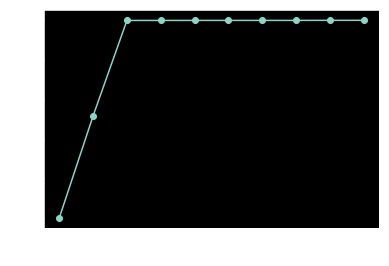

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()



## Attentionの可視化


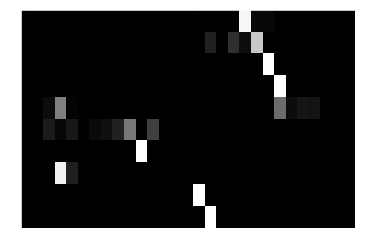

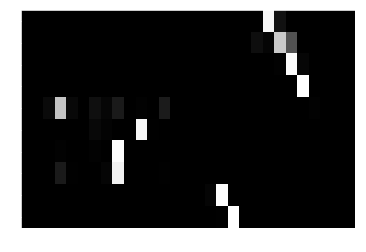

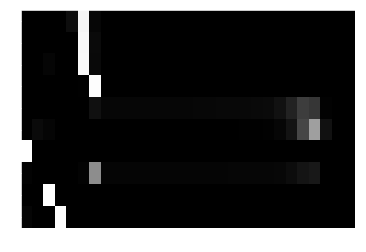

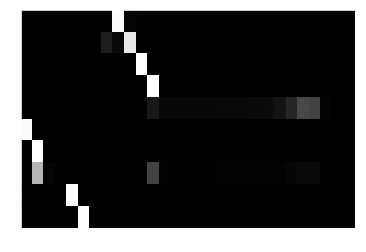

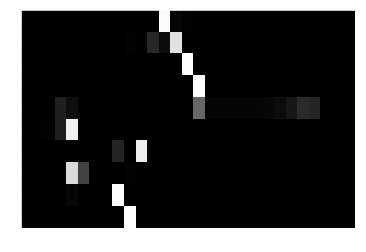

In [13]:
from dataset import sequence
import matplotlib.pyplot as plt


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

